In [1]:
# !pip install lime
# !pip install shap

In [2]:
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.datasets import load_breast_cancer
import warnings
random_state=42


# DATA

In [3]:
def load_breast_data():
    breast = load_breast_cancer()
    feature_names = list(breast.feature_names)
    X, y = pd.DataFrame(breast.data, columns=feature_names), breast.target
    dataset = {
        'problem': 'classification',
        'full': {
            'X': X,
            'y': y,
            'class_names': breast.target_names
        },
    }
    return dataset, feature_names

In [4]:
dataset, feature_names = load_breast_data()
X, y, class_names = dataset['full']['X'], dataset['full']['y'], dataset['full']['class_names'] 
class_name = 'label'

In [5]:
id2label = {i: class_names[i] for i in range(len(class_names))}

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=random_state)

In [7]:
train_df = X_train.copy(deep=True)
train_df [class_name] = y_train
test_df = X_test.copy(deep=True)
test_df [class_name] = y_test

In [8]:
train_df.head(n=5)

mean radius  mean texture  mean perimeter  mean area  mean smoothness   
337        18.77         21.43          122.90     1092.0          0.09116  \
91         15.37         22.76          100.20      728.2          0.09200   
270        14.29         16.82           90.30      632.6          0.06429   
20         13.08         15.71           85.63      520.0          0.10750   
40         13.44         21.58           86.18      563.0          0.08162   

     mean compactness  mean concavity  mean concave points  mean symmetry   
337           0.14020         0.10600              0.06090         0.1953  \
91            0.10360         0.11220              0.07483         0.1717   
270           0.02675         0.00725              0.00625         0.1508   
20            0.12700         0.04568              0.03110         0.1967   
40            0.06031         0.03110              0.02031         0.1784   

     mean fractal dimension  ...  worst texture  worst perimeter  worst area   
337                 0.06083  ...          34.37           161.10      1873.0  \
91                  0.06097  ...          25.84           107.50       830.9   
270                 0.05376  ...          20.65            94.44       684.6   
20                  0.06811  ...          20.49            96.09       630.5   
40                  0.05587  ...          30.25           102.50       787.9   

     worst smoothness  worst compactness  worst concavity   
337           0.14980            0.48270          0.46340  \
91            0.12570            0.19970          0.28460   
270           0.08567            0.05036          0.03866   
20            0.13120            0.27760          0.18900   
40            0.10940            0.20430          0.20850   

     worst concave points  worst symmetry  worst fractal dimension  label  
337               0.20480          0.3679                  0.09870      0  
91                0.14760          0.2556                  0.06828      0  
270               0.03333          0.2458                  0.06120      1  
20                0.07283          0.3184                  0.08183      1  
40                0.11120          0.2994                  0.07146      0  

[5 rows x 31 columns]

# RF

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state)
rf.fit(X_train.values, y_train)

pred = rf.predict(X_test.values)

sklearn.metrics.f1_score(y_test, pred, average='binary')

0.9652777777777778

# XAI

In [10]:
clf_predict_proba = rf.predict_proba
clf_predict = rf.predict
id_to_explain = 7
clf_predict_proba([X_test.iloc[id_to_explain]])

array([[0.85, 0.15]])

## LIME

In [11]:
# https://vishesh-gupta.medium.com/understanding-your-model-with-lime-d7704d984696

In [12]:
import lime
import lime.lime_tabular

In [13]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values[:,:], feature_names = feature_names, class_names=class_names,
                                                   categorical_features=None,
                                                   categorical_names=None,discretizer='decile',kernel_width=5,discretize_continuous=True,verbose=True)

In [14]:
exp = explainer.explain_instance(X_test.iloc[id_to_explain,:], clf_predict_proba, num_features=4)

Intercept 0.6207446637116096
Prediction_local [0.36646603]
Right: 0.15


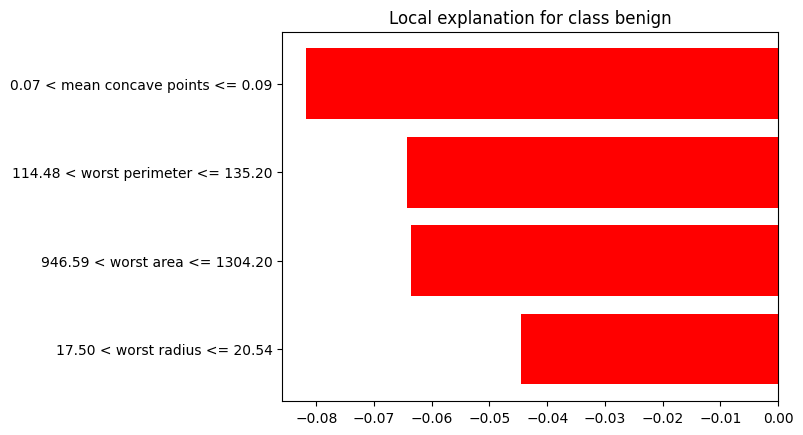

In [15]:
%matplotlib inline
fig = exp.as_pyplot_figure(label=1)

In [16]:
exp.show_in_notebook(show_all=False)

In [17]:
pd.DataFrame(exp.as_list(),columns=['Feature','Contribution'])

Feature  Contribution
0  0.07 < mean concave points <= 0.09     -0.081830
1  114.48 < worst perimeter <= 135.20     -0.064335
2      946.59 < worst area <= 1304.20     -0.063517
3       17.50 < worst radius <= 20.54     -0.044597

In [18]:
# Using discretize_continuous =False

In [19]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values[:,:],feature_names = feature_names,class_names=class_names,
                                                   categorical_features=None, 
                                                   categorical_names=None,kernel_width=5,discretize_continuous=False,verbose=True)

#getting the lime prediction for an observation
exp = explainer.explain_instance(X_test.iloc[id_to_explain,:],rf.predict_proba, num_features=4)

Intercept 0.49981919716599177
Prediction_local [0.40928278]
Right: 0.15


In [20]:
exp.show_in_notebook(show_all=False)

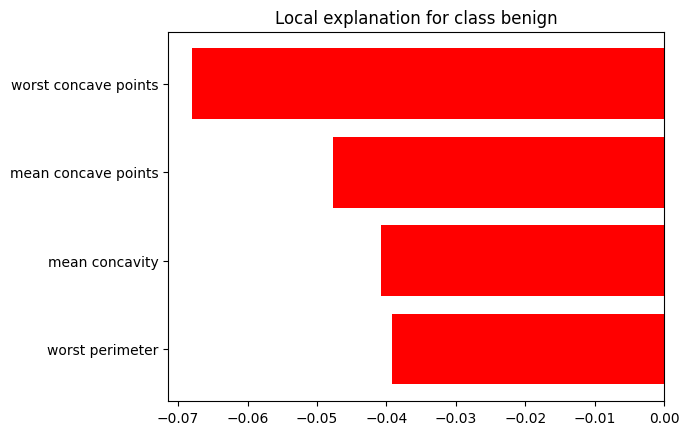

In [21]:
#variable level contribution
%matplotlib inline
fig = exp.as_pyplot_figure(label=1)

In [22]:
pd.DataFrame(exp.as_list(),columns=['Feature','Contribution'])

Feature  Contribution
0  worst concave points     -0.068005
1   mean concave points     -0.047682
2        mean concavity     -0.040733
3       worst perimeter     -0.039233

In [23]:
X_test.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

## SHAP

In [24]:
# https://safjan.com/kernelshap-treeshap-two-most-popular-variations-of-the-shap-method/
# https://www.kdnuggets.com/2023/08/shap-values-model-interpretability-machine-learning.html

In [25]:
import shap
shap.plots.initjs()

/home/atif/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

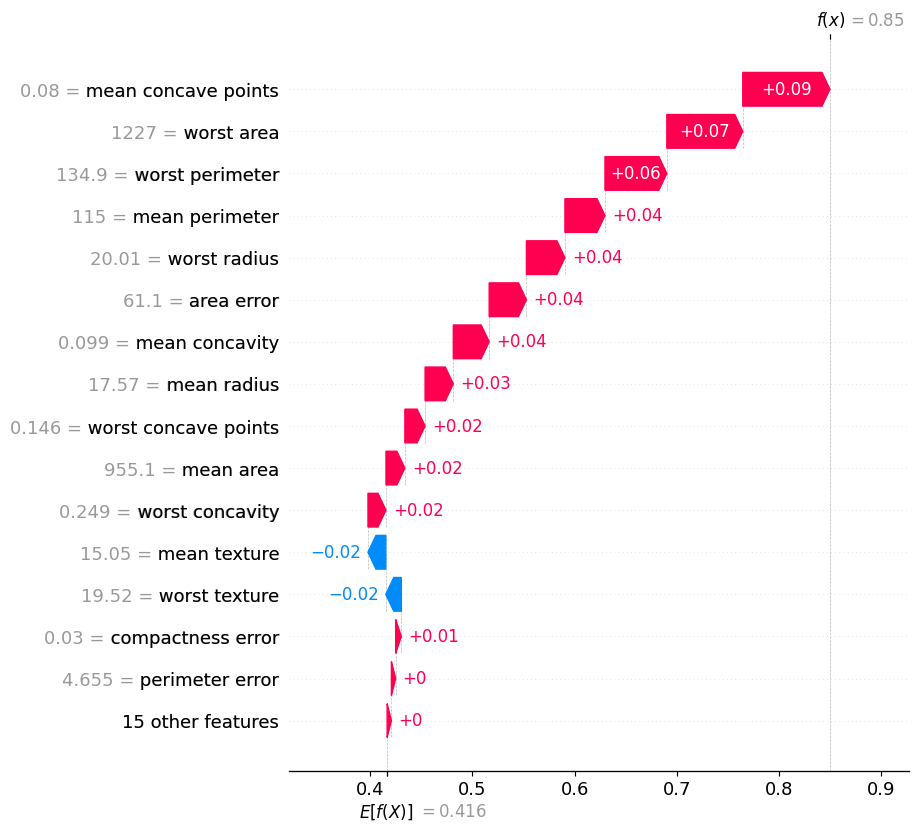

In [27]:
# https://github.com/shap/shap/issues/3172
exp = explainer(X_test)
output_to_explain = 0
shap.plots.waterfall(exp[id_to_explain,:,output_to_explain], max_display=16)
# shap.plots.waterfall(exp[id_to_explain,:,1], max_display=6)

In [28]:
shap_values[1].shape, X_test.shape

((30, 2), (456, 30))

In [29]:
shap_values[:,:,0].shape, X_test.shape

((456, 30), (456, 30))

In [30]:
shap.plots.force(explainer.expected_value[0], shap_values[id_to_explain,:,0], X_test.iloc[id_to_explain, :])

In [31]:
# https://www.youtube.com/watch?v=L8_sVRhBDLU&ab_channel=ADataOdyssey
shap.plots.force(explainer.expected_value[0], shap_values[id_to_explain:id_to_explain+10,:,0], feature_names=feature_names)
# shap.decision_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.columns)

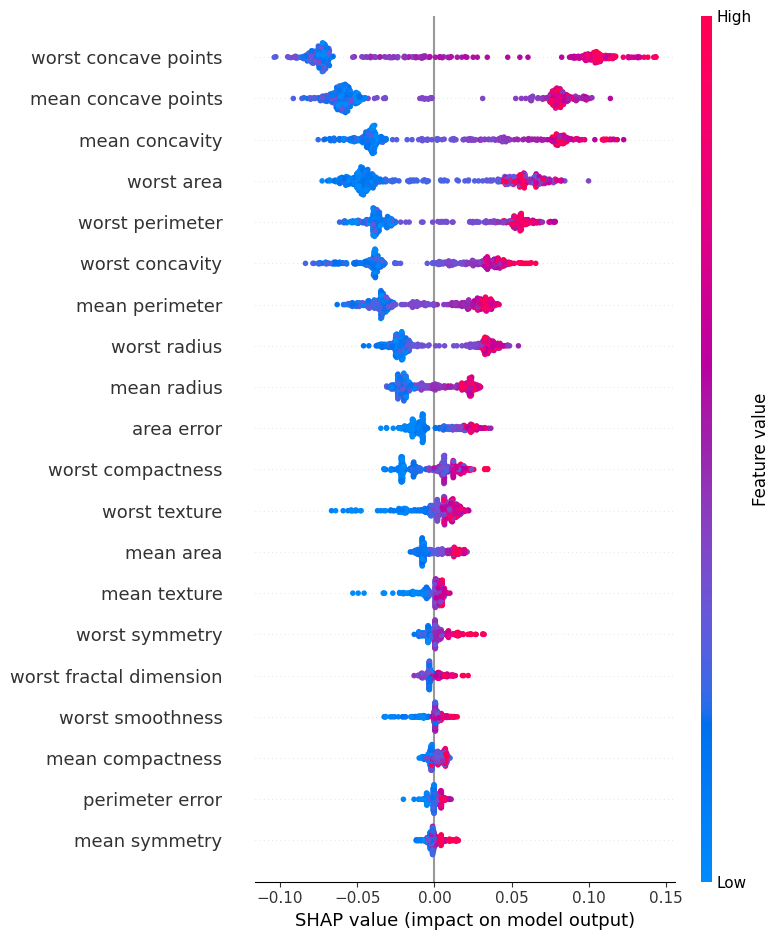

In [32]:
shap.summary_plot(shap_values[:,:,0], X_test)

## Anchors

In [33]:
# https://heka-ai.medium.com/use-anchor-to-better-understand-your-machine-learning-model-dd581f6d0f6f
# https://github.com/marcotcr/anchor/blob/master/notebooks/Anchor%20on%20tabular%20data.ipynb

In [34]:
# !pip install anchor-exp

In [35]:
from anchor import utils
from anchor import anchor_tabular
import re

In [36]:
explainer = anchor_tabular.AnchorTabularExplainer(
    class_names,
    feature_names,
    X_train.values[:,:],
    {})

In [37]:
print('Prediction: ', explainer.class_names[clf_predict([X_test.iloc[id_to_explain, :].values])[0]])

Prediction:  malignant


In [38]:
np.random.seed(random_state)
exp = explainer.explain_instance(X_test.iloc[id_to_explain, :].values, clf_predict, threshold=0.97)

In [39]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: concave points error <= 0.02 AND worst perimeter > 127.00 AND mean fractal dimension > 0.06
Precision: 1.00
Coverage: 0.03


In [40]:
exp.features()

[17, 22, 9]

In [41]:
def get_df_query_from_rules(exp_anchors):
    q = ''
    for anchor_name in exp_anchors:
        idx = re.search('<|>|=', anchor_name).start()
        if len(q):
            q += ' & '
        q += '`' + anchor_name[:idx-1] + '` ' + anchor_name[idx:]
    return q
anchor_query = get_df_query_from_rules(exp.names())
anchor_query

'`concave points error` <= 0.02 & `worst perimeter` > 127.00 & `mean fractal dimension` > 0.06'

In [42]:
X_test
X_test.query(anchor_query).shape

(48, 30)

In [43]:
print(exp.names())
fit_anchor = X_test.query(anchor_query)
np.mean(clf_predict(fit_anchor.values) == clf_predict([X_test.iloc[id_to_explain, :]]))

['concave points error <= 0.02', 'worst perimeter > 127.00', 'mean fractal dimension > 0.06']


1.0

In [44]:
# Get test examples where the anchor applies
print('Anchor test precision: %.2f' % (np.mean(clf_predict(fit_anchor.values) == clf_predict([X_test.iloc[id_to_explain, :]]))))
print('Anchor test coverage: %.2f' % (fit_anchor.shape[0] / float(X_test.shape[0])))

Anchor test precision: 1.00
Anchor test coverage: 0.11


## LORE

In [45]:
# https://www.ai4europe.eu/research/ai-catalog/lore
# https://github.com/rinziv/LORE_ext/blob/master/examples/lore_example.py
# https://doi.org/10.1109/ACCESS.2021.3116481 #Explainable Artificial Intelligence for Tabular Data: A Survey <-- can generate counterfactuals

In [46]:
# !pip install LORE-ext

In [47]:
from lore_explainer.util import neuclidean
from lore_explainer.lorem import LOREM

In [48]:
numeric_columns = list(X_test._get_numeric_data().columns)
numeric_columns

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst radius',
 'worst texture',
 'worst perimeter',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension']

In [49]:
from collections import defaultdict

def get_real_feature_names(rdf, numeric_columns, class_name):
    if isinstance(class_name, list):
        real_feature_names = [c for c in rdf.columns if c in numeric_columns and c not in class_name]
        real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c not in class_name]
    else:
        real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
        real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names
real_feature_names = get_real_feature_names(X_test, numeric_columns, class_name)
real_feature_names

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i].replace('%s=' % real_feature_names[j], '')] = i
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i].replace('%s=' % real_feature_names[j], '')] = i
            i += 1
        else:
            j += 1
    return features_map

features_map = get_features_map(feature_names, real_feature_names) #seems to exclude class label column, which is already cleaned
features_map

defaultdict(dict,
            {0: {'mean radius': 0},
             1: {'mean texture': 1},
             2: {'mean perimeter': 2},
             3: {'mean area': 3},
             4: {'mean smoothness': 4},
             5: {'mean compactness': 5},
             6: {'mean concavity': 6},
             7: {'mean concave points': 7},
             8: {'mean symmetry': 8},
             9: {'mean fractal dimension': 9},
             10: {'radius error': 10},
             11: {'texture error': 11},
             12: {'perimeter error': 12},
             13: {'area error': 13},
             14: {'smoothness error': 14},
             15: {'compactness error': 15},
             16: {'concavity error': 16},
             17: {'concave points error': 17},
             18: {'symmetry error': 18},
             19: {'fractal dimension error': 19},
             20: {'worst radius': 20},
             21: {'worst texture': 21},
             22: {'worst perimeter': 22},
             23: {'worst area': 23},
    

In [50]:
lore_explainer = LOREM(X_test.values, clf_predict, feature_names, class_name, id2label, numeric_columns, features_map,
                       neigh_type='geneticp', categorical_use_prob=True, continuous_fun_estimation=False,
                       size=1000, ocr=0.1, random_state=random_state, ngen=10, bb_predict_proba=clf_predict_proba,
                       verbose=True)

calculating feature values


In [51]:
exp = lore_explainer.explain_instance(X_test.iloc[id_to_explain].values, samples=1000, use_weights=True, metric=neuclidean)

print(exp)

generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	500   	0.496654	0.496654	0.496654
1  	433   	0.731693	0.496654	0.993307
2  	425   	0.936757	0.496654	0.993307
3  	433   	0.977141	0.484992	0.993307
4  	430   	0.978585	0.603639	0.993307
5  	435   	0.98295 	0.540775	0.993307
6  	434   	0.981418	0.579716	0.993307
7  	416   	0.980241	0.64985 	0.993307
8  	433   	0.979729	0.536772	0.993307
9  	423   	0.982877	0.715093	0.993307
10 	408   	0.982435	0.55595 	0.993307
gen	nevals	avg	min	max
0  	500   	0.5	0.5	0.5
1  	417   	0.50494	0.349897	0.736217
2  	420   	0.524608	0.354222	0.81972 
3  	425   	0.573042	0.402089	0.93109 
4  	438   	0.629512	0.170153	0.960098
5  	433   	0.672838	0.131908	0.960098
6  	431   	0.716241	0.404947	0.96641 
7  	429   	0.755522	0.33124 	0.966413
8  	415   	0.795666	0.367948	0.96641 
9  	418   	0.802829	0.394294	0.968004
10 	442   	0.801281	0.366125	0.968247
synthetic neighborhood class counts {'malignant': 527, 'benign': 673}
learning local

In [52]:
rule_query = get_df_query_from_rules(exp.rule._pstr()[1:-1].strip().split(', '))
rule_query

'`worst concave points` > 0.11 & `worst area` > 623.21 & `mean concave points` > 0.02 & `worst concavity` > 0.03 & `worst smoothness` > 0.09 & `fractal dimension error` > -0.00'

In [53]:
fit_rule = X_test.query(rule_query)
np.mean(clf_predict(fit_rule.values) == clf_predict([X_test.iloc[id_to_explain, :]]))

0.8938547486033519

In [54]:
# Get test examples where the anchor applies
print('Rule test precision: %.2f' % (np.mean(clf_predict(fit_rule.values) == clf_predict([X_test.iloc[id_to_explain, :]]))))
print('Rule test coverage: %.2f' % (fit_rule.shape[0] / float(X_test.shape[0])))

Rule test precision: 0.89
Rule test coverage: 0.39
